In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3 import HerReplayBuffer
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MazeEnv as mz
from MazeEnv.MazeEnv import Rewards
from MazeEnv.Utils import *
from Evaluation import EvalAndSaveCallback, clear_files
import Evaluation

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [80]:
TOTAL_TIME_STEPS = 1000 #number of training timesteps
TIMEOUT_STEPS = 300 # Timeout Steps of each episode
BUFFER_SIZE = 1000 # smaller buffer for small task
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5, idle=-0.01)

EVAL_EPISODES=1
EVAL_FREQ=200
VIDEO_FREQ=4

In [74]:
# create environment :
tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 4 / tile_size)
# maze_map = np.zeros(map_size)
TARGET_LOC = (5, 3)
START_LOC = np.divide(maze_size, 2)

maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                              maze_map=maze_map,
                              tile_size=tile_size,
                              start_loc=START_LOC,
                              target_loc=TARGET_LOC,
                              timeout_steps=TIMEOUT_STEPS,
                              show_gui=False,
                              rewards=REWARDS), 
                  filename="logs/MultiTargets/results")
_ = maze_env.reset()

check_env(maze_env)

# create separete evaluation environment:
eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=TARGET_LOC,
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = eval_maze_env.reset()
 
# create model:
model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device=device,
             train_freq=(1, "episode"),
             verbose=1)

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/MultiTargets",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=2)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [75]:
start = time.time()

#clean all movies from the previous run
clear_files('logs/MultiTargets/*_steps.avi')

torch.manual_seed(3295)
model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback)
 
print("time", time.time() - start)

200 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
--Saving new best model--
400 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
600 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
800 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
creating video
1000 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
1200 Steps evaluation, avg reward:-3.49, avg episode length: 300.0
rewards: [-3.49]
episode lengths: [300]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | -3.49    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 21       |
|    time_elapsed    | 55       |
|    total timesteps | 1200     |
| train/       

Wrapping the env in a DummyVecEnv.
Reward: -3.4899999999999802


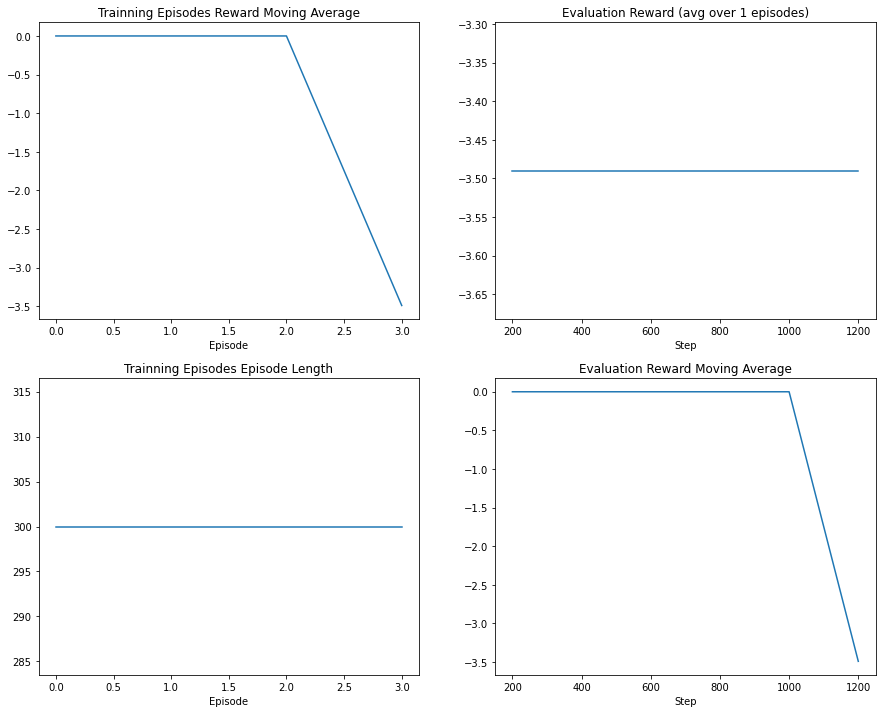

In [78]:
from IPython.display import Image
import ipyplot
import glob

# load & Evaluates the best model 
best_model = DDPG.load("./logs/MultiTargets/best_model",env=maze_env)
Evaluation.plot_train_eval_results("logs/MultiTargets", EVAL_EPISODES)

episode_reward = Evaluation.record_model(best_model, eval_maze_env, "logs/MultiTargets/final.avi")
print("Reward:", episode_reward)

Evaluation.create_gifs_from_avi("logs/MultiTargets")

#Clean previous gifs
clear_files('logs/MultiTargets/*_steps.gif')

# Plot gifs
gifs = glob.glob("logs/MultiTargets/*.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)
